# 2. Feature Engineering

This notebook transforms raw stock price data into meaningful statistical features used for machine learning.

We'll calculate:
- Log returns
- Rolling volatility
- Drawdowns
- Correlations
- Sharpe ratio
- Skewness & kurtosis

These features allow us to understand each asset's behavior over time and form a quantitative profile for clustering and anomaly detection.

## Import Required Libraries
Again, we import the necessary Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import os

### a. SP500 Tickers

## 1. Load Price Data
We begin by importing pre-cleaned OHLCV (Open, High, Low, Close, Volume) data for the S&P 500 tickers.

In [2]:
folder_path_sp500 = "../data/processed/sp500/"
combined_df_sp500 = None

for filename in os.listdir(folder_path_sp500):
    if filename.endswith(".csv"):
        ticker = filename.replace(".csv", "") 
        filepath = os.path.join(folder_path_sp500, filename)

        df = pd.read_csv(filepath, usecols=["Price", "Close"])
        df.rename(columns={"Close": ticker}, inplace=True)
        df.set_index("Price", inplace=True)

        if combined_df_sp500 is None:
            combined_df_sp500 = df
        else:
            combined_df_sp500 = combined_df_sp500.join(df, how='inner')

combined_df_sp500.index.name = "Date"
combined_df_sp500.columns.name = None
combined_df_sp500 = combined_df_sp500.drop(combined_df_sp500.index[0])

## 2. Compute Log Returns
Log returns are preferred in finance due to their additive properties and better statistical behavior compared to simple returns.

In [3]:
log_returns_sp500 = np.log(combined_df_sp500.astype(float) / combined_df_sp500.astype(float).shift(1)).dropna()

In [4]:
log_returns_sp500.tail()

,AAPL,AMZN,CAT,GOOGL,JNJ,JPM,MSFT,NEE,TSLA,XOM
Date,,,,,,,,,,
2024-12-24,0.011413,0.017573,0.005948,0.007575,0.003985,0.016310,0.009330,0.005777,0.070991,0.000940
2024-12-26,0.003171,-0.008770,-0.001225,-0.002604,-0.001853,0.003420,-0.002781,-0.007434,-0.017787,0.000845
2024-12-27,-0.013331,-0.014641,-0.006175,-0.014626,-0.003647,-0.008135,-0.017453,-0.003599,-0.050745,-0.000094
2024-12-30,-0.013352,-0.011010,-0.005083,-0.007917,-0.011859,-0.007701,-0.013328,-0.004866,-0.033569,-0.006785
2024-12-31,-0.007083,-0.008668,-0.000689,-0.010196,0.008890,0.001628,-0.007869,-0.000976,-0.033050,0.016969


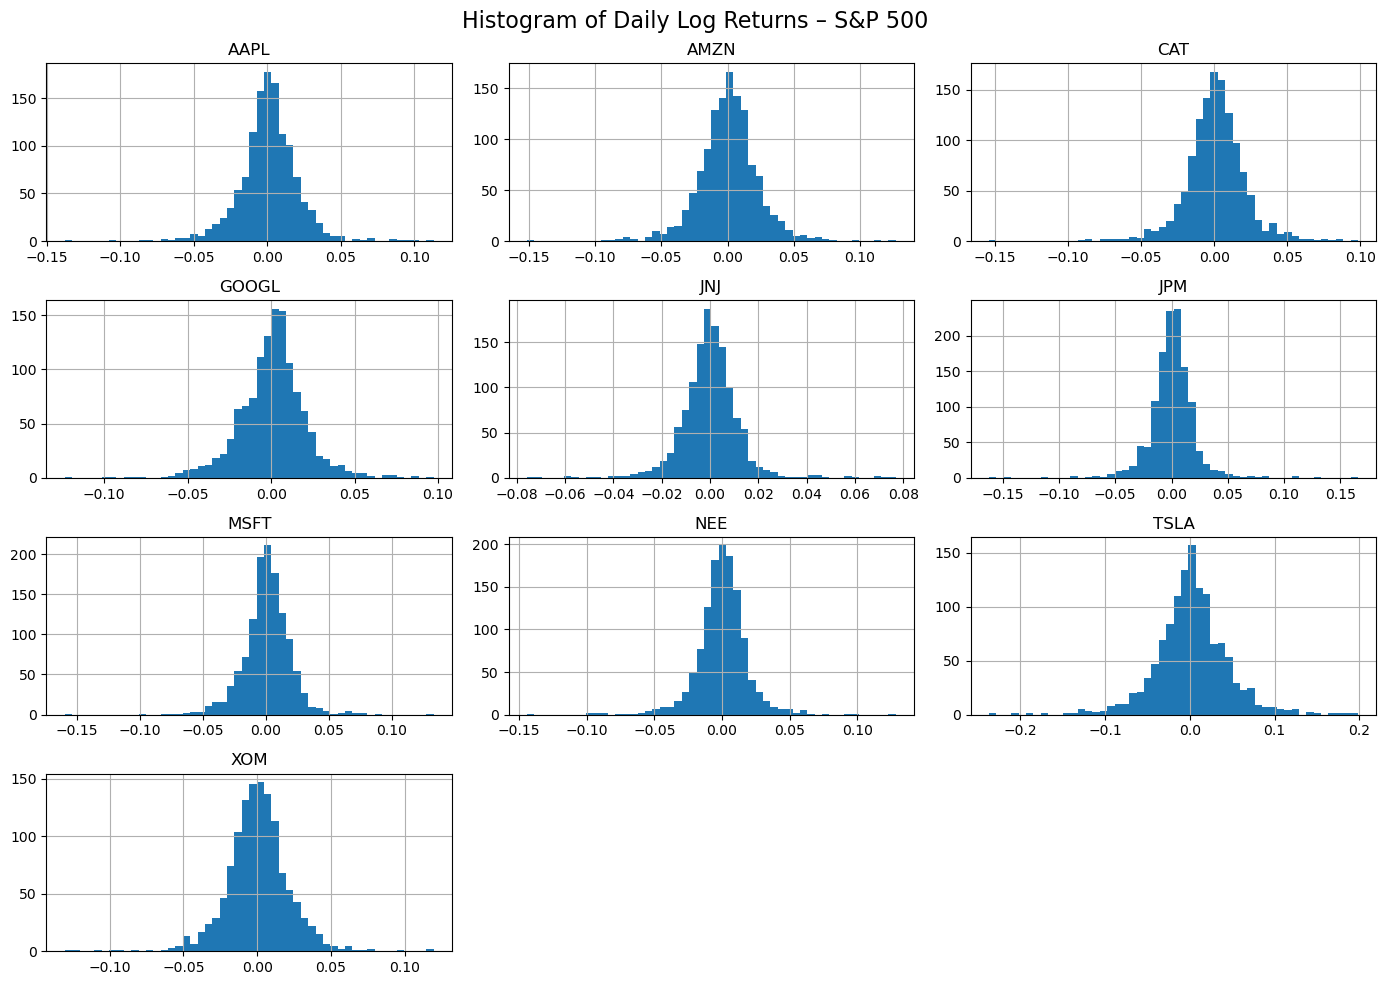

In [5]:
log_returns_sp500.hist(bins=50, figsize=(14, 10))
plt.suptitle("Histogram of Daily Log Returns – S&P 500", fontsize=16)
plt.tight_layout()
plt.show()

### Observations: Histogram of Daily Log Returns – S&P 500

- **General Shape**: Most tickers exhibit roughly normal (bell-shaped) distributions centered around 0, which is typical for daily log returns in liquid equities.
- **Fat Tails**:
  - **TSLA** shows significantly heavier tails and a wider spread than the rest — consistent with its higher volatility and susceptibility to price swings.
  - **AMZN** and **GOOGL** also exhibit moderate tail risk, with a few larger return events.
- **Outlier Events**:
  - **TSLA**, **JPM**, and **CAT** show occasional return spikes outside ±10%, suggesting the presence of rare high-magnitude movements.
- **Symmetry**:
  - Most distributions are fairly symmetric. However, **CAT** and **JPM** display slight skewness — with more pronounced negative or positive tails.
- **Tight Distributions**:
  - **JNJ**, **MSFT**, and **NEE** show tighter, more peaked distributions, indicating lower day-to-day variability in returns.
- **Implication**: These distribution characteristics directly impact our upcoming volatility and Sharpe Ratio calculations. Heavier tails and wider spreads may affect clustering and anomaly detection downstream.


## 3. Compute Rolling Volatility
Volatility represents risk. Rolling volatility shows how risk changes over time. We compute a 30-day rolling standard deviation of log returns.

In [6]:
rolling_volatility_sp500 = log_returns_sp500.rolling(window=30).std().dropna()

In [7]:
rolling_volatility_sp500.head()

,AAPL,AMZN,CAT,GOOGL,JNJ,JPM,MSFT,NEE,TSLA,XOM
Date,,,,,,,,,,
2020-02-14,0.016556,0.016563,0.015986,0.013114,0.006383,0.011276,0.014394,0.007292,0.061446,0.014710
2020-02-18,0.016856,0.016308,0.015909,0.013024,0.006101,0.011278,0.014045,0.007409,0.062101,0.014772
2020-02-19,0.016969,0.016201,0.015928,0.012302,0.006102,0.011572,0.014042,0.009416,0.062624,0.014772
2020-02-20,0.017083,0.016352,0.015803,0.012360,0.006091,0.011119,0.014311,0.009395,0.063054,0.014770
2020-02-21,0.017491,0.017179,0.015690,0.013151,0.006339,0.011263,0.015708,0.009360,0.062954,0.014709


## 4. Compute Maximum Drawdowns
Drawdown measures the peak-to-trough decline, giving insight into downside risk.

In [8]:
combined_df_sp500 = combined_df_sp500.astype(float)
peak_sp500 = combined_df_sp500.cummax()
drawdowns_sp500 = (combined_df_sp500 - peak_sp500) / peak_sp500 

In [9]:
drawdowns_sp500

,AAPL,AMZN,CAT,GOOGL,JNJ,JPM,MSFT,NEE,TSLA,XOM
Date,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,-0.009722,-0.012139,-0.013884,-0.005231,-0.011578,-0.013196,-0.012452,0.000000,0.000000,-0.008039
2020-01-06,-0.001831,0.000000,-0.014548,0.000000,-0.012811,-0.013981,-0.009899,0.000000,0.000000,-0.000423
2020-01-07,-0.006525,0.000000,-0.027569,-0.001932,-0.006782,-0.030744,-0.018927,-0.000869,0.000000,-0.008604
2020-01-08,0.000000,-0.007809,-0.018933,0.000000,-0.006919,-0.023183,-0.003300,-0.001325,0.000000,-0.023554
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.000000,-0.016657,-0.118283,-0.002797,-0.150089,-0.031883,-0.056799,-0.155983,-0.036636,-0.144338
2024-12-26,0.000000,-0.025244,-0.119363,-0.005390,-0.151663,-0.028567,-0.059419,-0.162234,-0.053620,-0.143615
2024-12-27,-0.013242,-0.039411,-0.124784,-0.019831,-0.154751,-0.036438,-0.075692,-0.165244,-0.100446,-0.143695


In [10]:
cumulative_sp500 = (log_returns_sp500 + 1).cumprod()

running_max_sp500 = cumulative_sp500.cummax()
drawdown_sp500 = (cumulative_sp500 - running_max_sp500) / running_max_sp500
max_drawdown_sp500 = drawdown_sp500.min()

In [11]:
max_drawdown_sp500

AAPL    -0.351789
AMZN    -0.618939
CAT     -0.401653
GOOGL   -0.479546
JNJ     -0.290193
JPM     -0.467463
MSFT    -0.406100
NEE     -0.490705
TSLA    -0.798813
XOM     -0.582714
dtype: float64

## 5. Compute Correlation Matrix
We compute the average correlation for each ticker across the dataset. Highly correlated assets move together.

In [12]:
avg_corr_sp500 = log_returns_sp500.corr().mean()

In [13]:
avg_corr_sp500

AAPL     0.533582
AMZN     0.447384
CAT      0.439299
GOOGL    0.511883
JNJ      0.382922
JPM      0.476826
MSFT     0.545175
NEE      0.406328
TSLA     0.375800
XOM      0.383478
dtype: float64

## 6. Sharpe Ratio
A common risk-adjusted performance measure. It tells us how much return an asset offers per unit of risk.

In [14]:
sharpe_ratio_sp500 = log_returns_sp500.mean()/(log_returns_sp500.std()) * np.sqrt(252)

In [15]:
sharpe_ratio_sp500

AAPL     0.782477
AMZN     0.467213
CAT      0.609368
GOOGL    0.629397
JNJ      0.132271
JPM      0.416758
MSFT     0.662888
NEE      0.198120
TSLA     0.791351
XOM      0.384412
dtype: float64

In [16]:
vol_sp500 = log_returns_sp500.std().dropna()

In [17]:
vol_sp500

AAPL     0.019940
AMZN     0.022652
CAT      0.020504
GOOGL    0.020488
JNJ      0.012356
JPM      0.020441
MSFT     0.019228
NEE      0.019208
TSLA     0.042205
XOM      0.021663
dtype: float64

## 7. Skewness & Kurtosis
These are higher moments of the distribution:
- **Skewness** measures asymmetry.
- **Kurtosis** measures tail heaviness.

Both give insight into the statistical shape of asset returns.

In [18]:
skewness_sp500 = log_returns_sp500.apply(skew, axis=0)
kurt_sp500 = log_returns_sp500.apply(kurtosis, axis=0)

## 8. Assemble Summary DataFrame
We create a summary DataFrame with all computed features per ticker. This will serve as input for the machine learning models in the next notebook.

In [19]:
summary_df_sp500 = pd.DataFrame({
    "Avg Correlation": avg_corr_sp500,
    "Volatility": vol_sp500,
    "Max Drawdown": max_drawdown_sp500,
    "Skewness": skewness_sp500,
    "Kurtosis": kurt_sp500,
    "Sharpe Ratio": sharpe_ratio_sp500
    
})

summary_df_sp500 = summary_df_sp500.round(4)
summary_df_sp500 = summary_df_sp500.sort_index()

In [20]:
summary_df_sp500

,Avg Correlation,Volatility,Max Drawdown,Skewness,Kurtosis,Sharpe Ratio
AAPL,0.5336,0.0199,-0.3518,-0.1123,5.3572,0.7825
AMZN,0.4474,0.0227,-0.6189,-0.1335,4.0688,0.4672
CAT,0.4393,0.0205,-0.4017,-0.3349,5.0060,0.6094
GOOGL,0.5119,0.0205,-0.4795,-0.2285,3.7270,0.6294
JNJ,0.3829,0.0124,-0.2902,0.2490,8.0422,0.1323
JPM,0.4768,0.0204,-0.4675,0.0024,12.5127,0.4168
MSFT,0.5452,0.0192,-0.4061,-0.2836,7.5159,0.6629
NEE,0.4063,0.0192,-0.4907,-0.4462,7.8081,0.1981
TSLA,0.3758,0.0422,-0.7988,-0.1118,3.2210,0.7914
XOM,0.3835,0.0217,-0.5827,-0.1634,4.6385,0.3844


In [21]:
summary_df_sp500.columns = summary_df_sp500.columns.astype(str).str.strip()
features_sp500 = summary_df_sp500.columns.tolist()

In [22]:
summary_df_sp500.to_pickle("../data/processed/sp500_summary.pkl")

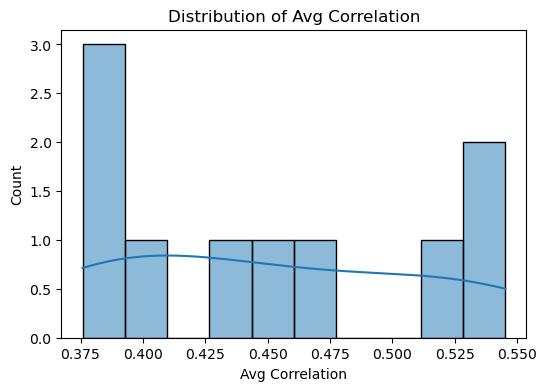

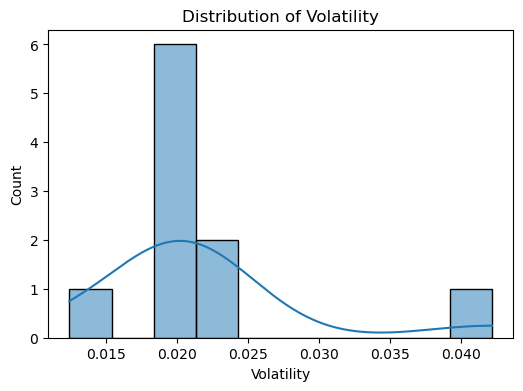

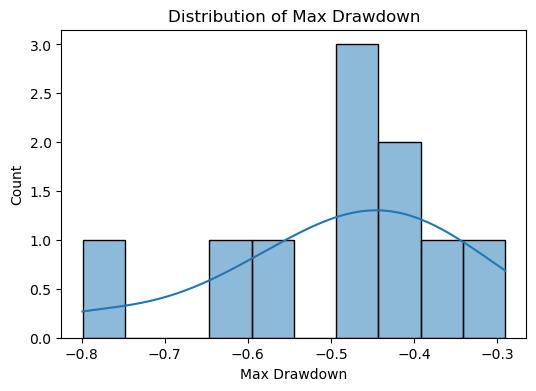

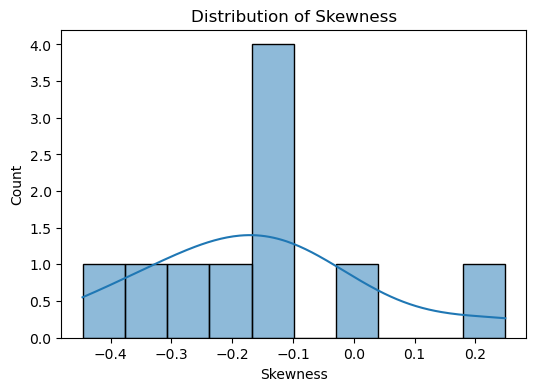

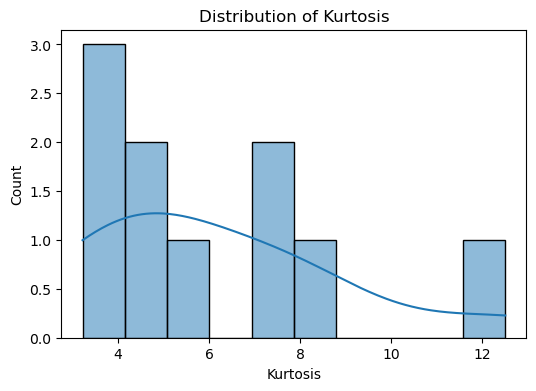

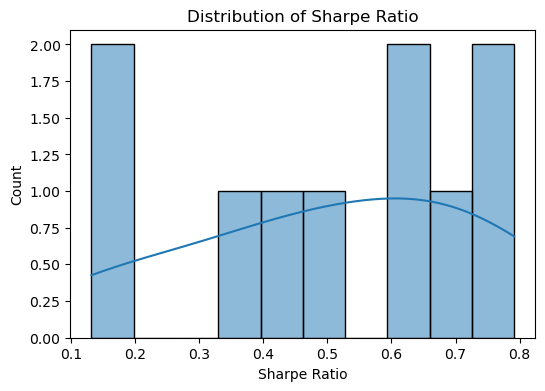

In [23]:
for col in features_sp500:
    plt.figure(figsize=(6, 4))
    sns.histplot(summary_df_sp500[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.show()

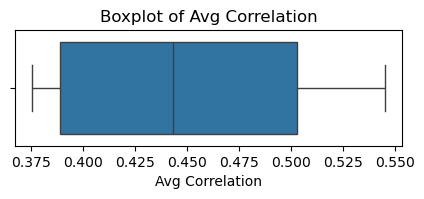

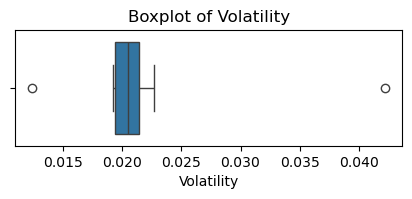

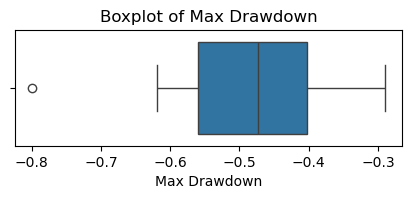

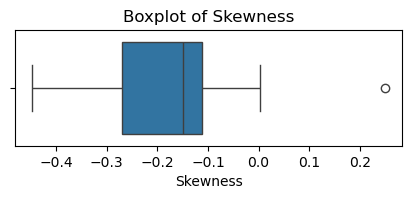

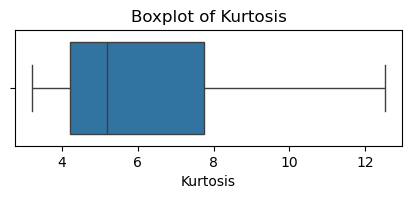

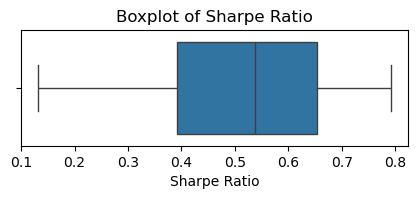

In [24]:
for col in features_sp500:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=summary_df_sp500[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

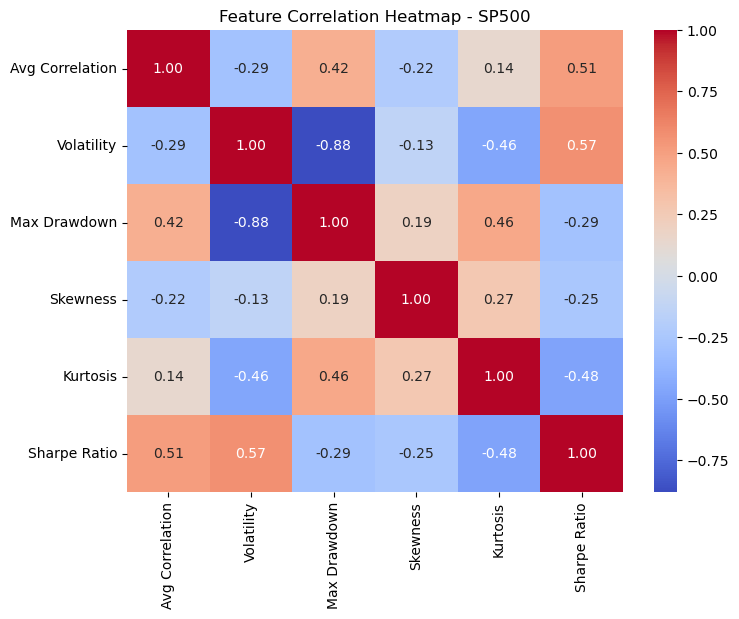

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(summary_df_sp500.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap - SP500")
plt.show()

### Observations: Feature Correlation Heatmap – S&P 500

- **Volatility vs Max Drawdown**:  
  Strong **negative correlation (-0.88)**, which is expected — high volatility often corresponds to deeper drawdowns, confirming their shared role as downside risk indicators.

- **Volatility vs Sharpe Ratio**:  
  **Positive correlation (0.57)** — while Sharpe Ratio typically penalizes volatility, this suggests some high-volatility assets still had strong returns. Possibly driven by high-growth stocks like TSLA or AAPL.

- **Max Drawdown vs Sharpe Ratio**:  
  **Negative correlation (-0.29)** — as expected, assets with deeper drawdowns tend to have lower Sharpe Ratios.

- **Kurtosis vs Sharpe Ratio**:  
  **Negative correlation (-0.48)** — indicates that assets with fat tails (extreme movements) tend to have lower Sharpe performance.

- **Avg Correlation vs Sharpe Ratio**:  
  Moderate **positive correlation (0.51)** — assets moving more in sync with others may still maintain decent risk-adjusted returns, which is worth noting in portfolio diversification strategy.

- **Skewness** shows weak correlations with most features — indicating it's a more idiosyncratic property of return distributions, not tightly coupled with broader risk metrics.

The heatmap confirms intuitive financial relationships (e.g., volatility-drawdown link), while also highlighting nuanced behavior (e.g., high-volatility assets performing well). These correlations will influence both dimensionality reduction and clustering logic in subsequent steps.


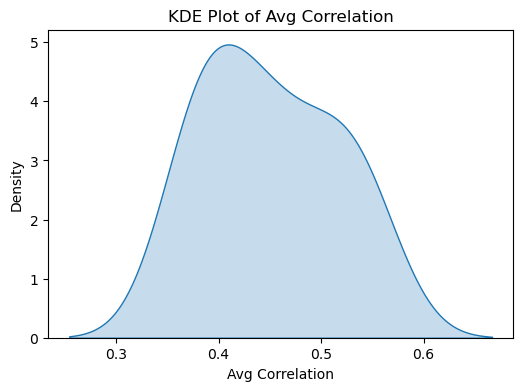

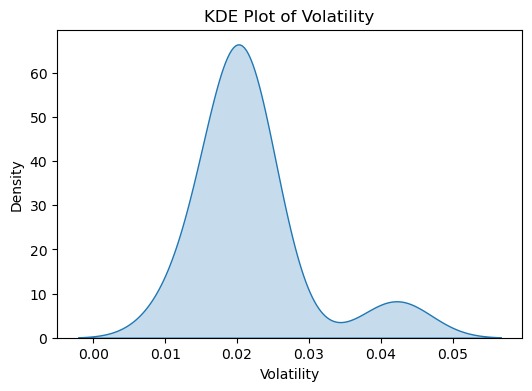

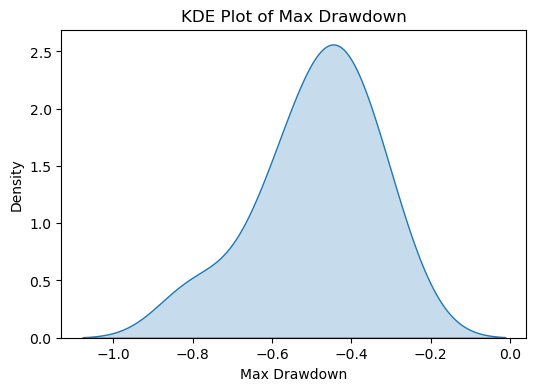

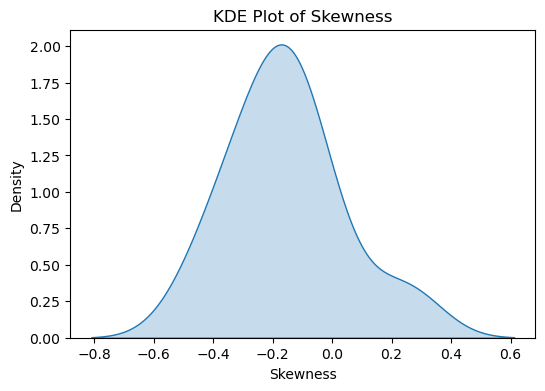

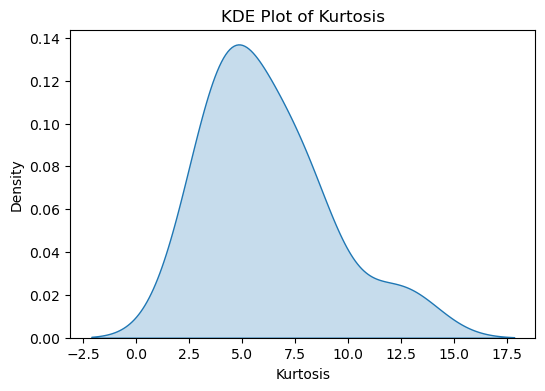

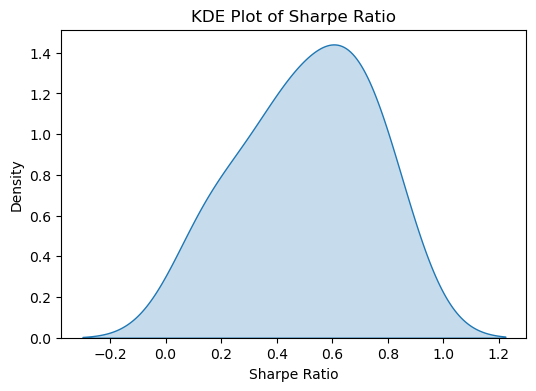

In [26]:
for col in features_sp500:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(summary_df_sp500[col], fill=True)
    plt.title(f"KDE Plot of {col}")
    plt.show()

### b. FTSE100 Tickers

## 1. Load Price Data
We import the cleaned data for the FTSE 100 tickers.

In [28]:
folder_path_ftse100 = "../data/processed/ftse100/"
combined_df_ftse100 = None

for filename in os.listdir(folder_path_ftse100):
    if filename.endswith(".csv"):
        ticker = filename.replace(".csv", "") 
        filepath = os.path.join(folder_path_ftse100, filename)

        df = pd.read_csv(filepath, usecols=["Price", "Close"])
        df.rename(columns={"Close": ticker}, inplace=True)
        df.set_index("Price", inplace=True)

        if combined_df_ftse100 is None:
            combined_df_ftse100 = df
        else:
            combined_df_ftse100 = combined_df_ftse100.join(df, how='inner')

combined_df_ftse100.index.name = "Date"
combined_df_ftse100.columns.name = None
combined_df_ftse100 = combined_df_ftse100.drop(combined_df_ftse100.index[0])

## 2. Compute Log Returns
Log returns are preferred in finance due to their additive properties and better statistical behavior compared to simple returns.

In [29]:
log_returns_ftse100 = np.log(combined_df_ftse100.astype(float) / combined_df_ftse100.astype(float).shift(1)).dropna()

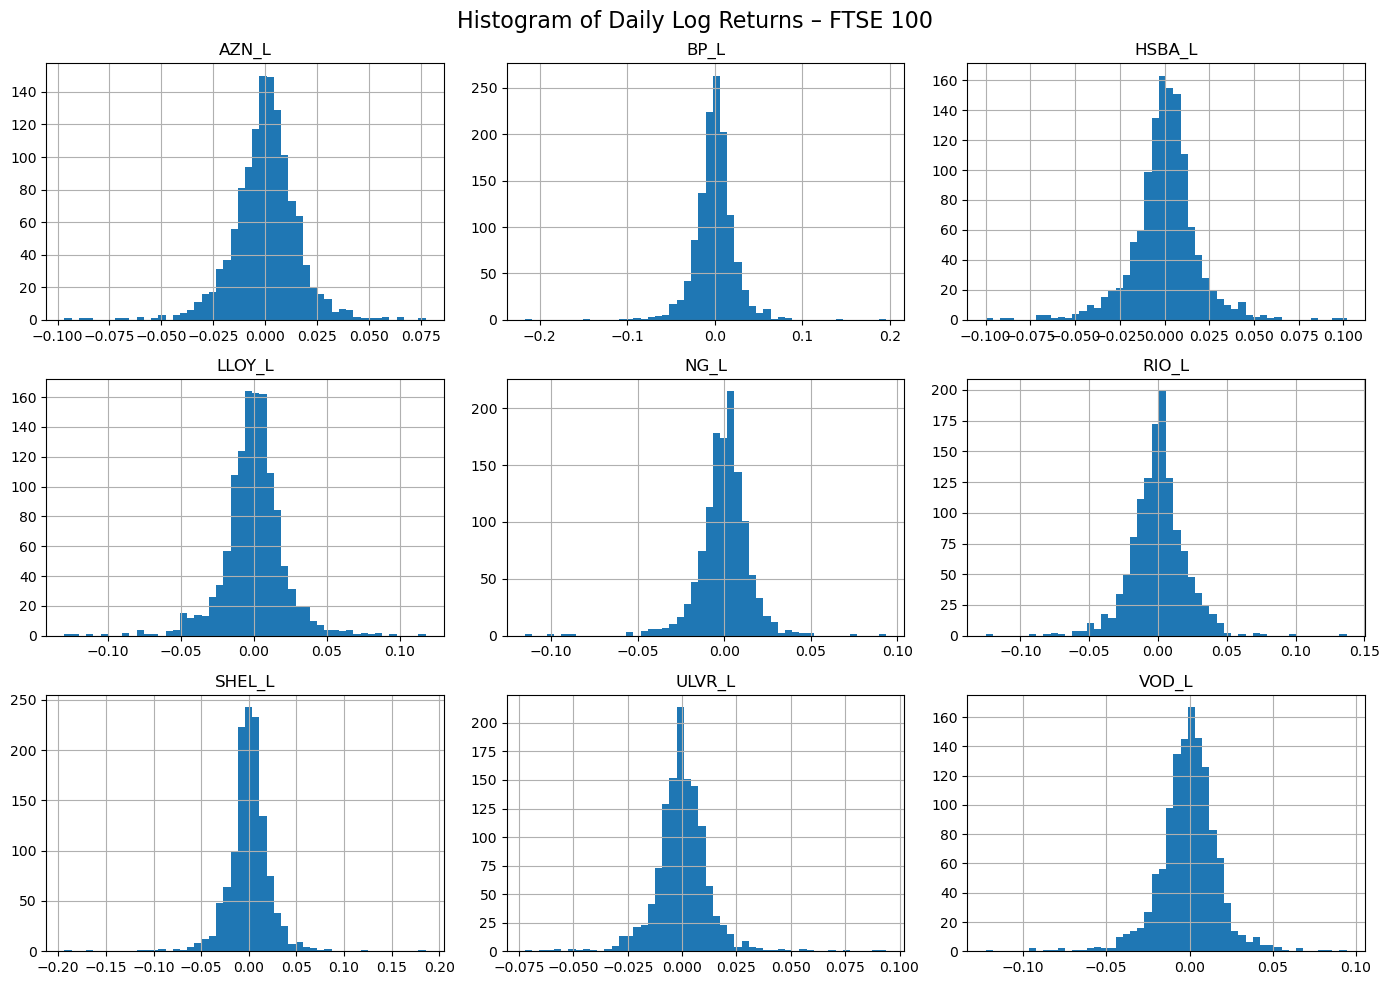

In [47]:
log_returns_ftse100.hist(bins=50, figsize=(14, 10))
plt.suptitle("Histogram of Daily Log Returns – FTSE 100", fontsize=16)
plt.tight_layout()
plt.show()

### Observations: Histogram of Daily Log Returns – FTSE 100

- **Overall Shape**: Most assets show symmetric bell-shaped curves, centered near zero — typical of log returns for large-cap stocks in a developed market.
- **Wider Distributions**:
  - **BP_L** and **VOD_L** exhibit wider return spreads and fatter tails, suggesting occasional larger daily movements.
  - **SHEL_L** also shows considerable variability, with a flatter and wider distribution compared to others.
- **Tight & Peaked Distributions**:
  - **HSBA_L**, **NG_L**, and **ULVR_L** are more narrowly concentrated around the mean, implying lower daily volatility.
- **Outlier Spikes**:
  - **BP_L** has a visible outlier spike on the positive side beyond 10%, suggesting a rare extreme event — possibly linked to energy market news.
- **Skewness**:
  - While most tickers are symmetric, **RIO_L** and **AZN_L** show slight asymmetries — one skewed toward gains, the other toward losses.
- **Comparative Insight**:
  - The FTSE 100 overall appears slightly less volatile than the S&P 500 based on histogram width and height.
  - These distributions will impact risk metrics like volatility and Sharpe ratios used in clustering.


## 3. Compute Rolling Volatility
Volatility represents risk. Rolling volatility shows how risk changes over time. We compute a 30-day rolling standard deviation of log returns.

In [30]:
rolling_volatility_ftse100 = log_returns_ftse100.rolling(window=30).std().dropna()

## 4. Compute Maximum Drawdowns
Drawdown measures the peak-to-trough decline, giving insight into downside risk.

In [31]:
combined_df_ftse100 = combined_df_ftse100.astype(float)
peak_ftse100 = combined_df_ftse100.cummax()
drawdowns_ftse100 = (combined_df_ftse100 - peak_ftse100) / peak_ftse100 

In [32]:
cumulative_ftse100 = (log_returns_ftse100 + 1).cumprod()

running_max_ftse100 = cumulative_ftse100.cummax()
drawdown_ftse100 = (cumulative_ftse100 - running_max_ftse100) / running_max_ftse100
max_drawdown_ftse100 = drawdown_ftse100.min()

## 5. Compute Correlation Matrix
We compute the average correlation for each ticker across the dataset. Highly correlated assets move together.

In [33]:
avg_corr_ftse100 = log_returns_ftse100.corr().mean()

## 6. Sharpe Ratio
A common risk-adjusted performance measure. It tells us how much return an asset offers per unit of risk.

In [34]:
sharpe_ratio_ftse100 = log_returns_ftse100.mean()/(log_returns_ftse100.std()) * np.sqrt(252)

In [35]:
vol_ftse100 = log_returns_ftse100.std().dropna()

## 7. Skewness & Kurtosis
These are higher moments of the distribution:
- **Skewness** measures asymmetry.
- **Kurtosis** measures tail heaviness.

Both give insight into the statistical shape of asset returns.

In [36]:
skewness_ftse100 = log_returns_ftse100.apply(skew, axis=0)
kurt_ftse100 = log_returns_ftse100.apply(kurtosis, axis=0)

## 8. Assemble Summary DataFrame
We create a summary DataFrame with all computed features per ticker. This will serve as input for the machine learning models in the next notebook.

In [37]:
summary_df_ftse100 = pd.DataFrame({
    "Avg Correlation": avg_corr_ftse100,
    "Volatility": vol_ftse100,
    "Max Drawdown": max_drawdown_ftse100,
    "Skewness": skewness_ftse100,
    "Kurtosis": kurt_ftse100,
    "Sharpe Ratio": sharpe_ratio_ftse100
    
})

summary_df_ftse100 = summary_df_ftse100.round(4)
summary_df_ftse100 = summary_df_ftse100.sort_index()

In [38]:
summary_df_ftse100

,Avg Correlation,Volatility,Max Drawdown,Skewness,Kurtosis,Sharpe Ratio
AZN_L,0.2888,0.0158,-0.2868,-0.3794,4.2318,0.2496
BP_L,0.4768,0.0231,-0.6670,-0.2967,13.1480,-0.1084
HSBA_L,0.4389,0.0181,-0.5512,-0.2237,4.3711,0.1943
LLOY_L,0.4340,0.0214,-0.6590,-0.3453,5.3922,-0.0878
NG_L,0.3374,0.0145,-0.3583,-0.9845,9.5565,0.0017
RIO_L,0.3926,0.0198,-0.4046,-0.0659,4.4804,0.0294
SHEL_L,0.4729,0.0220,-0.6645,-0.5853,13.6382,0.0543
ULVR_L,0.3095,0.0129,-0.3423,0.5562,8.8925,0.0459
VOD_L,0.4081,0.0180,-0.6654,-0.5410,5.4747,-0.5372


In [39]:
summary_df_ftse100.columns = summary_df_ftse100.columns.astype(str).str.strip()
features_ftse100 = summary_df_ftse100.columns.tolist()

In [40]:
summary_df_ftse100.to_pickle("../data/processed/ftse100_summary.pkl")

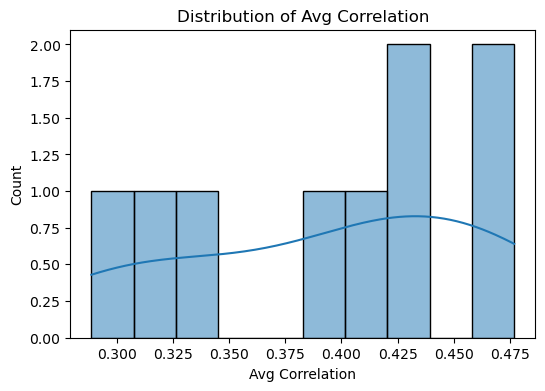

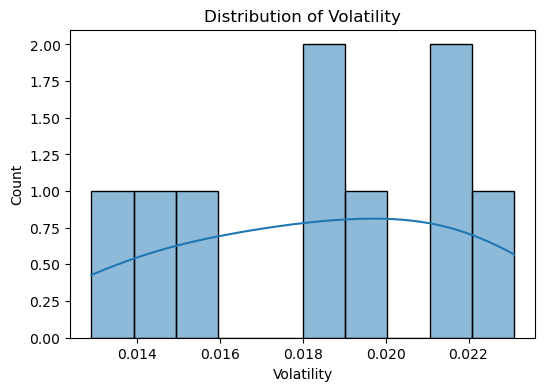

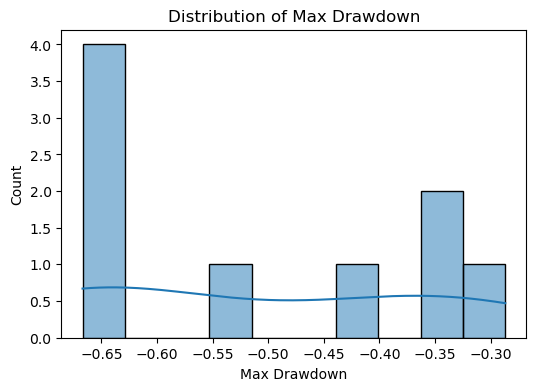

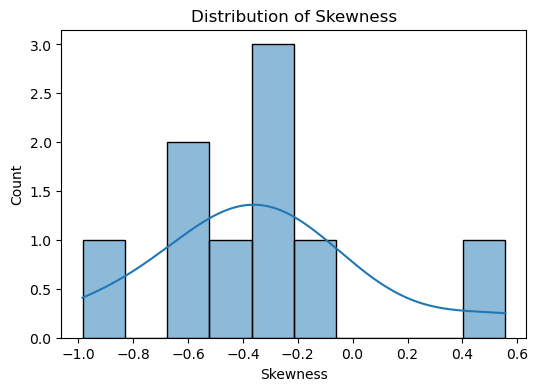

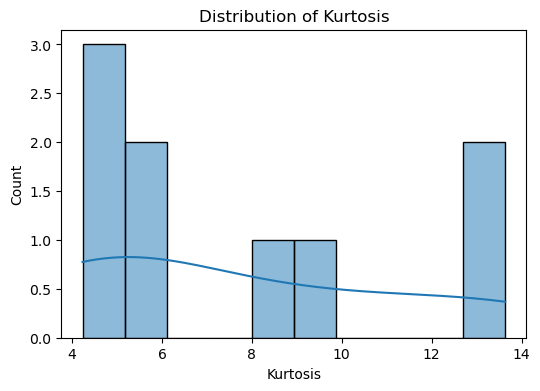

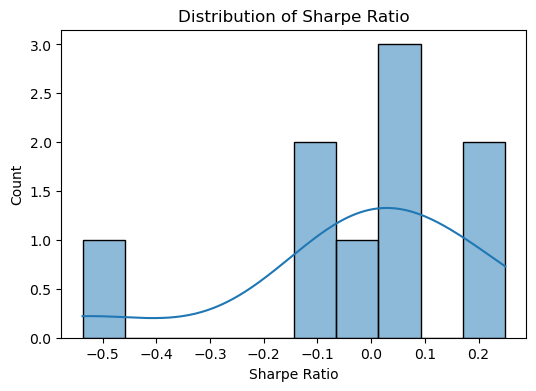

In [41]:
for col in features_ftse100:
    plt.figure(figsize=(6, 4))
    sns.histplot(summary_df_ftse100[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.show()

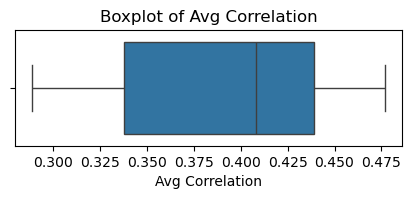

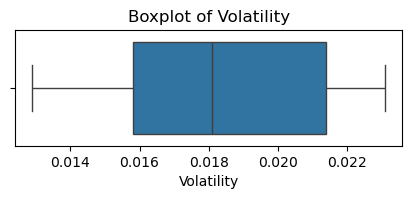

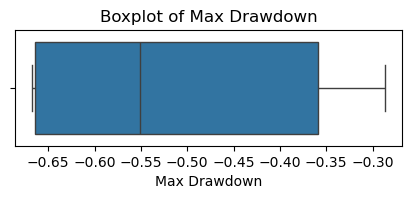

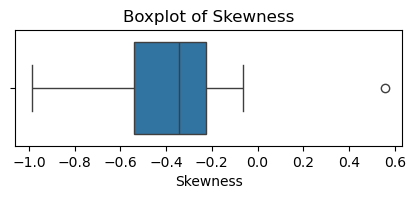

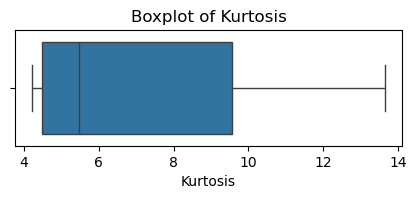

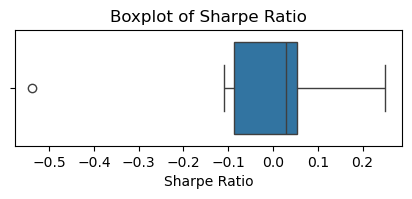

In [44]:
for col in features_ftse100:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=summary_df_ftse100[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

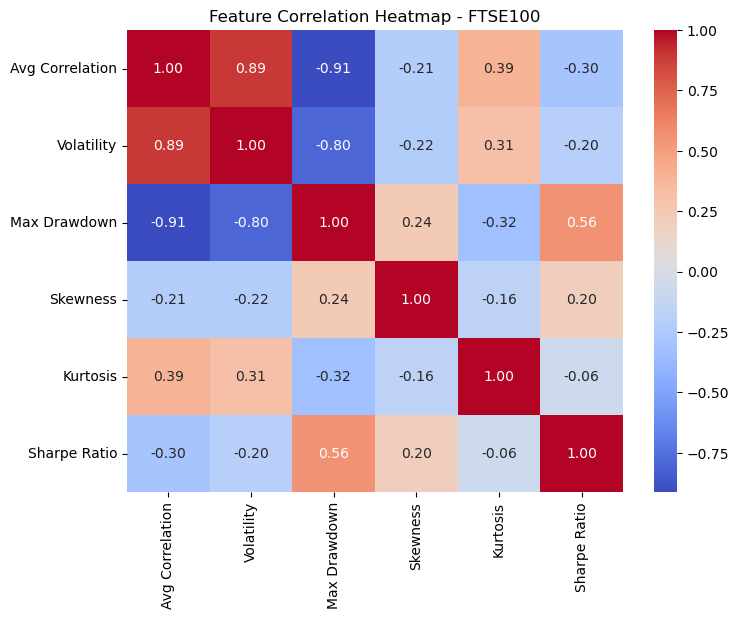

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(summary_df_ftse100.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap - FTSE100")
plt.show()

### Observations: Feature Correlation Heatmap – FTSE 100

- **Avg Correlation vs Max Drawdown**:  
  Very strong **negative correlation (-0.91)**. Assets that tend to move with the rest of the market also tend to suffer larger drawdowns — likely due to being more exposed to systemic risk.

- **Volatility vs Max Drawdown**:  
  Strong **negative correlation (-0.80)**. This reinforces the relationship observed in the S&P 500 — volatile assets are more prone to significant losses during downturns.

- **Max Drawdown vs Sharpe Ratio**:  
  **Positive correlation (0.56)** — somewhat counterintuitive, suggesting that some assets with larger drawdowns still delivered high average returns. This might reflect temporary rebounds or cyclical risk-taking.

- **Avg Correlation vs Volatility**:  
  **Very strong positive correlation (0.89)** — implies that stocks which are more "in sync" with the market also tend to be more volatile. Could indicate herd behavior in UK equities.

- **Kurtosis and Skewness**:  
  Show weak to moderate correlations with other features — they're more descriptive of distribution shape and less tied to systemic risk metrics.

- **Sharpe Ratio vs All Others**:  
  Mixed relationships. Notably:
  - Weak negative correlations with **Avg Correlation (-0.30)** and **Volatility (-0.20)**.
  - Slight positive correlation with **Max Drawdown (0.56)** — similar to earlier anomaly and worth further inspection.

The FTSE 100 exhibits stronger correlations between systemic metrics than the S&P 500, possibly due to its more sector-concentrated composition (e.g., energy, finance). These findings will shape the interpretation of clusters and anomalies later in the pipeline.


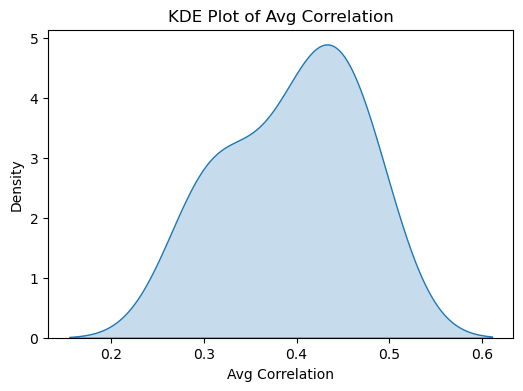

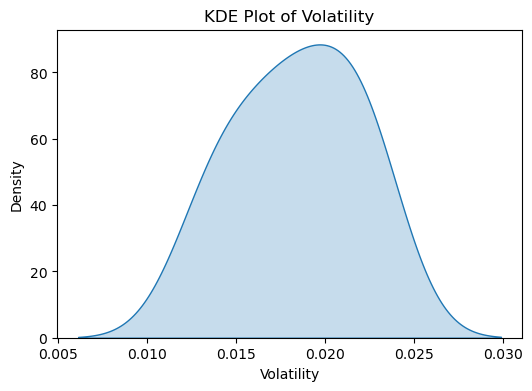

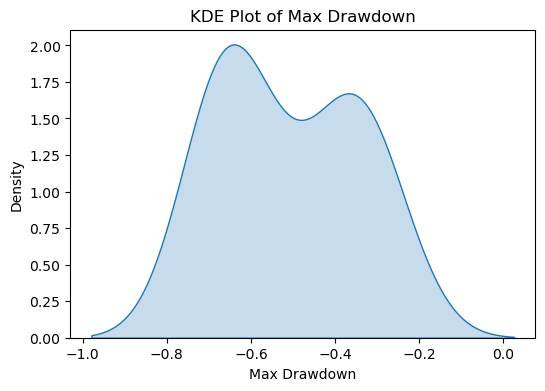

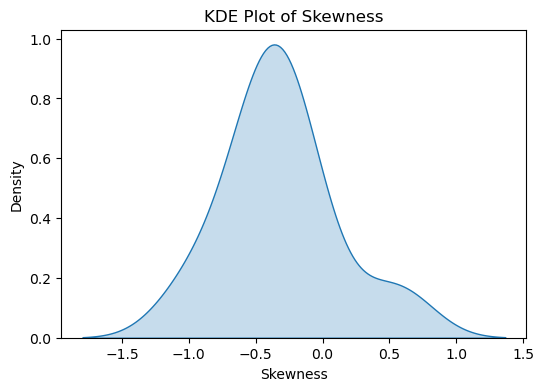

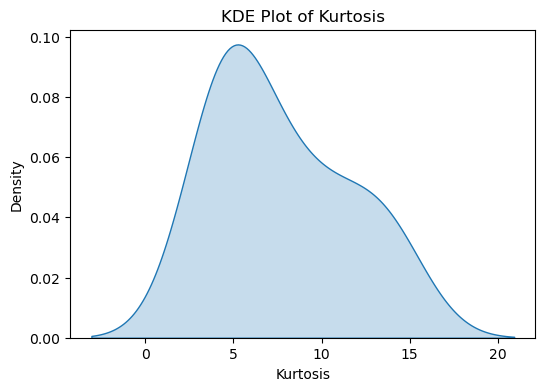

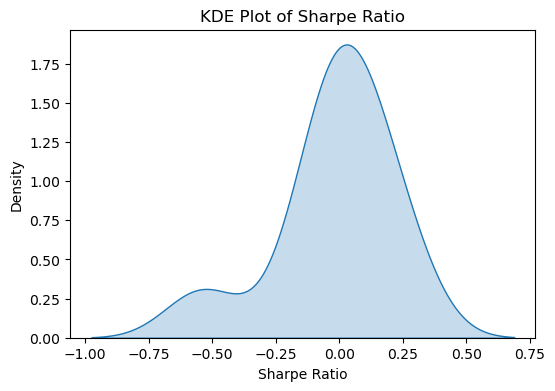

In [46]:
for col in features_ftse100:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(summary_df_ftse100[col], fill=True)
    plt.title(f"KDE Plot of {col}")
    plt.show()